In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format, col

In [2]:
sc = SparkContext().getOrCreate()
ss = SparkSession.builder.getOrCreate()

In [58]:
one_month = ss.read.csv('../Data/output1month.csv', header=True)
schedules = ss.read.csv('../Data/Meter_Rate_Schedules.csv', header=True).withColumnRenamed("Post ID", "POST_ID")
meters = ss.read.csv('../Data/Parking_meters.csv', header=True)
irving = ss.read.csv('../Data/Irving2200_1month.csv', header=True)

In [4]:
# Change all column names to uppercase
for col in schedules.columns:
    schedules = schedules.withColumnRenamed(col, "_".join(col.split()).upper())

In [5]:
schedules.write.saveAsTable("Schedules")
one_month.write.saveAsTable("Transactions")
meters.write.saveAsTable("Meters")

In [6]:
sched_base = ss.sql("""
SELECT POST_ID, AVG_RATE AS RATE, HAS_OVERRIDE FROM (

    SELECT POST_ID, AVG_RATE, CASE WHEN num >= 2 THEN 1 ELSE 0 END HAS_OVERRIDE FROM
    (
        SELECT *,
        count(1) OVER(
        PARTITION BY POST_ID
        ) num,
        AVG(RATE) OVER(
        PARTITION BY POST_ID
        ) AVG_RATE

        FROM Schedules
    )    
)
GROUP BY 1, 2, 3
""")
sched_base.write.saveAsTable('Schedules_Base')

In [7]:
meter_dummy = ss.sql("""
SELECT POST_ID,
RATE,
HAS_OVERRIDE,
CASE WHEN CAP_COLOR = 'Green' THEN 1 ELSE 0 END GREEN,
CASE WHEN CAP_COLOR = 'Grey' THEN 1 ELSE 0 END GREY
FROM
Schedules_Base
join
(
    SELECT * FROM Meters
    WHERE (Meters.CAP_COLOR = 'Green' OR Meters.CAP_COLOR = 'Grey')
)
USING(POST_ID)
""")

In [8]:
block_post = ss.sql("""
    SELECT STREET_BLOCK, POST_ID
    FROM Transactions
    GROUP BY 1,2
    ORDER BY 1
""")

In [9]:
block_post_full = block_post.join(meter_dummy, how='inner', on='POST_ID')

In [10]:
block_post_full.write.saveAsTable("Post_block")

In [11]:
block_info = ss.sql("""
SELECT STREET_BLOCK,
MAX(RATE) RATE,
SUM(HAS_OVERRIDE) NUM_OR,
SUM(GREEN) NUM_GREEN,
SUM(GREY) NUM_GREY
FROM Post_block
GROUP BY 1
""")

In [12]:
block_info.show()

+----------------+------------------+------+---------+--------+
|    STREET_BLOCK|              RATE|NUM_OR|NUM_GREEN|NUM_GREY|
+----------------+------------------+------+---------+--------+
|    16TH ST 2900|               2.0|     0|        2|      17|
|  HAIGHT ST 1600|               2.0|     0|        1|      23|
|COLUMBUS AVE 800|               2.0|     0|        2|       9|
|       KERN ST 0|               2.0|     0|        0|       3|
|     KING ST 300|1.1666666666666667|     4|        0|       4|
|  HOWARD ST 1400|               2.0|     0|        4|      17|
|    JONES ST 800|               3.0|     0|        1|      18|
| GEARY BLVD 3800|               2.0|     0|        0|      13|
|     03RD ST 100|               3.5|     0|        0|      15|
|    GROVE ST 100|            1.6875|     6|        2|       4|
|   24TH AVE 2500|               2.0|     0|        0|       4|
|     08TH ST 600|               2.0|     0|       10|       8|
|COLUMBUS AVE 400|               2.0|   

In [13]:
block_info.count()

1294

## K-Means clustering

In [25]:
block_info.show()

+----------------+------------------+------+---------+--------+
|    STREET_BLOCK|              RATE|NUM_OR|NUM_GREEN|NUM_GREY|
+----------------+------------------+------+---------+--------+
|    16TH ST 2900|               2.0|     0|        2|      17|
|  HAIGHT ST 1600|               2.0|     0|        1|      23|
|COLUMBUS AVE 800|               2.0|     0|        2|       9|
|       KERN ST 0|               2.0|     0|        0|       3|
|     KING ST 300|1.1666666666666667|     4|        0|       4|
|  HOWARD ST 1400|               2.0|     0|        4|      17|
|    JONES ST 800|               3.0|     0|        1|      18|
| GEARY BLVD 3800|               2.0|     0|        0|      13|
|     03RD ST 100|               3.5|     0|        0|      15|
|    GROVE ST 100|            1.6875|     6|        2|       4|
|   24TH AVE 2500|               2.0|     0|        0|       4|
|     08TH ST 600|               2.0|     0|       10|       8|
|COLUMBUS AVE 400|               2.0|   

In [14]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(outputCol="features", inputCols=block_info.columns[1:]) #except the last col.
block_feat = va.transform(block_info)

In [15]:
from pyspark.ml.clustering import KMeans
kmeans =  KMeans(k = 90, maxIter = 200, tol = 0.1) # k = 10 as there are 10 different handwritten numbers.
model = kmeans.fit(block_feat)

In [17]:
# import math
# # Evaluate clustering by computing Within Set Sum of Squared Errors
# num_k = []
# wcss = []
# avgd = []
# for i in range(5, 600, 15):
#     kmeans =  KMeans(k = i, maxIter = 100, tol = 0.1) # k = 10 as there are 10 different handwritten numbers.
#     model = kmeans.fit(block_feat)
#     wssse = model.computeCost(block_feat) 
# #     print('Clusters =', i)
#     num_k.append(i)
#     wcss.append(wssse)
#     avgd.append(math.sqrt(wssse/block_info.count()))
# #     print("Within Set Sum of Squared Errors = " + str(wssse))
# #     print("Average distance from the center = " + str(math.sqrt(wssse/block_info.count())))
# #     print()

In [ ]:
# # Shows the result.
# centers = model.clusterCenters()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)

In [ ]:
model.transform(block_feat).select('STREET_BLOCK', 'RATE', 'NUM_OR', 'NUM_GREEN', 'NUM_GREY', 'PREDICTION')\
    .withColumnRenamed('PREDICTION', 'CLUSTER').show()

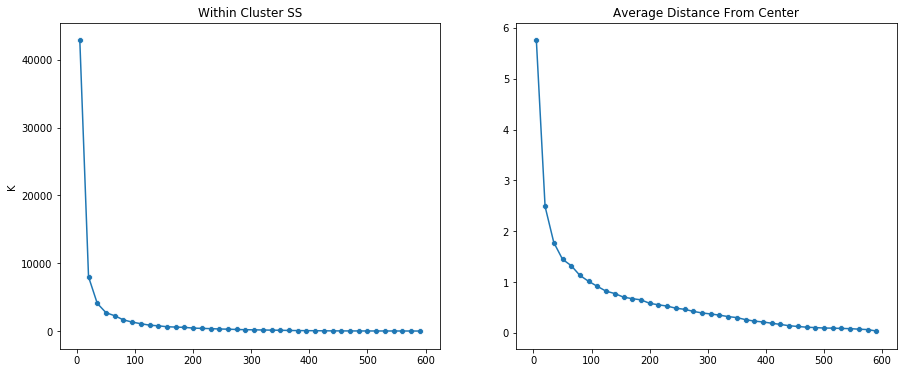

In [21]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
# sns.lineplot(list(range(5,600,15)), wcss, ax = ax[0])
# sns.scatterplot(list(range(5,600,15)), wcss, ax = ax[0])
# ax[0].set_title('Within Cluster SS')
# ax[0].set_ylabel('K')

# sns.lineplot(list(range(5,600,15)), avgd, ax = ax[1])
# sns.scatterplot(list(range(5,600,15)), avgd, ax = ax[1])
# ax[1].set_title('Average Distance From Center')
# plt.show()

In [29]:
from datetime import datetime
from pyspark.sql.functions import col, udf

In [27]:
ss.sql("""
select TO_DATE(CAST(UNIX_TIMESTAMP(SESSION_START_DT, 'MM/dd/yyyy') AS TIMESTAMP))
from transactions
limit 5
""").show()

+--------------------+
|    SESSION_START_DT|
+--------------------+
|19-OCT-18 11.00.0...|
|13-OCT-18 03.30.3...|
|29-OCT-18 12.40.3...|
|30-OCT-18 01.36.1...|
|05-OCT-18 09.42.0...|
+--------------------+



In [66]:
# Creation of a dummy dataframe:

# Setting an user define function:
# This function converts the string cell into a date:
func =  udf (lambda x: datetime.strptime(x, '%d-%b-%y %H.%M.%S %p'), TimestampType())

df = irving.withColumn('test', func(col('SESSION_START_DT')))


In [67]:
df.show()

+---+---------+--------------+------------+--------------------+--------------------+----------------+--------------+-------------------+
|_c0|  POST_ID|  STREET_BLOCK|PAYMENT_TYPE|    SESSION_START_DT|      SESSION_END_DT|METER_EVENT_TYPE|GROSS_PAID_AMT|               test|
+---+---------+--------------+------------+--------------------+--------------------+----------------+--------------+-------------------+
|  1|490-22370|IRVING ST 2200| CREDIT CARD|01-OCT-18 01.06.5...|01-OCT-18 02.06.5...|              NS|          2.25|2018-10-01 01:06:55|
|  2|490-22370|IRVING ST 2200|        CASH|01-OCT-18 03.24.3...|01-OCT-18 03.31.1...|              NS|          0.25|2018-10-01 03:24:30|
|  3|490-22370|IRVING ST 2200|        CASH|01-OCT-18 03.37.1...|01-OCT-18 03.50.3...|              NS|           0.5|2018-10-01 03:37:14|
|  4|490-22370|IRVING ST 2200| PAY BY CELL|01-OCT-18 03.59.0...|01-OCT-18 04.59.0...|              NS|          2.25|2018-10-01 03:59:00|
|  5|490-22370|IRVING ST 2200| PAY

In [69]:
one_month.select('POST_ID', 'STREET_BLOCK').write.saveAsTable('test')